# Module 5 Final Project Submission

Please fill out:
* Student name: Fernando Aguilar Islas
* Student pace: Part-time
* Scheduled project review date/time: TBD
* Instructor name: Brandon Lewis
* Blog post URL: TBD


## 1. Introduction
For this project I will use the Online Shoppers Purchasing Intention Dataset which contains information about website visitors and their behaviour on the site. This dataset tracks the user as revenue generating or not. The aim of this project is to build a model that can accurately calssify a user as revenue generating or not given his behavior when visiting the website.

## 2 Framework
Using this dataset, I will first perform EDA to categorize the features in the dataset as numerical, continuous or discrete, and categorical variables. To help in this process I will use histograms, distribution plots and box plots, to assess the information contained in the data set. Furthermore, I will look for missing values and outliers to deal with them appropriately.

### 2.1 Import Required Libraries

In [242]:
# EDA tools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(10)
import warnings
warnings.filterwarnings("ignore")

#Single model classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

#Ensemble classifications models
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

#Model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,confusion_matrix, classification_report,roc_curve, roc_auc_score,
f1_score, recall_score, precision_score)

# Imbalance, Hyperparameter tunning and pipelines
from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tpot import TPOTClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

## 2.2 Helper Functions

In [281]:
def distbox_plot(data):
    '''Function to plot a seaborn distribution plot 
        with a box plot on top'''
    # Cut the window in 2 parts
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(14,4),gridspec_kw={"height_ratios": (.15, .85)})
    # Add a graph in each part
    sns.boxplot(data, ax=ax_box)
    sns.distplot(data, ax=ax_hist)
    # Remove x axis name for the boxplot
    ax_box.set(xlabel='')
    #Print describtive statistics
    print(data.describe())
    
def best_k(X_train, y_train, X_test, y_test, min_k=1, max_k=10):
    best_k = 0
    best_score = 0.0
    for k in range(min_k, max_k+1, 2):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        preds = knn.predict(X_test)
        f1 = f1_score(y_test, preds)
        if f1 > best_score:
            best_k = k
            best_score = f1

def baseline_models(X,y,sort='f1'):
    models=[KNeighborsClassifier(),DecisionTreeClassifier(),LinearSVC(),LogisticRegression(),
            RandomForestClassifier(),xgb.XGBClassifier()]
    X_train, X_test, y_train, y_test = train_test_split(X,y)
    accuracy = []
    f1 = []
    auc = []
    recall = []
    precision = []
    for model in models:
        print('Classification Model: ',model,'\n')
        clf = model
        clf.fit(X_train, y_train)
        test_preds = clf.predict(X_test)
        f1.append(f1_score(y_test, test_preds))
        accuracy.append(accuracy_score(y_test, test_preds))
        auc.append(roc_auc_score(y_test, test_preds))
        recall.append(recall_score(y_test, test_preds))
        precision.append(precision_score(y_test, test_preds))
        print(classification_report(y_test, test_preds),'\n')
    results = pd.DataFrame([f1,accuracy, precision,recall,auc],
                      index= ['f1','accuracy','precision','recall','auc'],
                           columns=['KNeighbors','DecisionTree','LinearSVC',
                                    'LogisticRegression','RandomForest','XGBoost'])
    return results.transpose()

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    <scki-kit learn sample function.
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


## 3. Exploratory Data Analysis


In [3]:
#Load the file into a pandas data frame.
data = pd.read_csv("online_shoppers_intention.csv")
#Get structural information of the data set.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
Administrative             12330 non-null int64
Administrative_Duration    12330 non-null float64
Informational              12330 non-null int64
Informational_Duration     12330 non-null float64
ProductRelated             12330 non-null int64
ProductRelated_Duration    12330 non-null float64
BounceRates                12330 non-null float64
ExitRates                  12330 non-null float64
PageValues                 12330 non-null float64
SpecialDay                 12330 non-null float64
Month                      12330 non-null object
OperatingSystems           12330 non-null int64
Browser                    12330 non-null int64
Region                     12330 non-null int64
TrafficType                12330 non-null int64
VisitorType                12330 non-null object
Weekend                    12330 non-null bool
Revenue                    12330 non-null bool
dtypes: bool(

The dataset contains 18 coluns total of which 17 are features and 1 is the target variable, in this instance, 'Revenue'. Below is a description of waht each column means in the dataset:

* Administrative: Number of 'administrative' pages viewed
* Administrative_Duration: Time spent looking at 'administrative' pages
* Informational: Number of 'informational' pages viewed
* Informational_Duration: Time spent looking at 'informational' pages
* ProductRelated: Number of 'product related' pages viewed
* ProductRelated_Duration: Time spent looking at 'product related' pages
* BounceRates: The percentage of visitors who enter the site from that page and then leave ("bounce") without triggering any other requests to the analytics server during that session
* ExitRates: It is calculated as for all pageviews to the page, the percentage that were the last in the session
* PageValues: Represents the average value for a web page that a user visited before completing an e-commerce transaction
* SpecialDay: Indicates the closeness of the site visiting time to a specific special day (e.g. Mother’s Day, Valentine's Day) in which the sessions are more likely to be finalized with transaction
* Month: Month of the year for the session
* OperatingSystems: Operating system used for the session
* Browser: Browser used for the session
* Region: Region of the user
* TrafficType: Traffic Type
* VisitorType: Types of Visitor
* Weekend: Session occured on a weekend or not
* RevenueRevenue: Represents whether the user generated reveue or not

It looks like the data contains numerical and non-numerical variables. Let's look at the first few rows of the dataset.


In [4]:
#Visualize first 5 rows of data of the first 9 columns.
data.head().iloc[:,:9]

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0


In [5]:
#Visualize first 5 rows of data of the remaining columns.
data.head().iloc[:,9:]

,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


From this first inspection at the data contained in the dataset, some of the numerical features are actually categorical such as OperatingSystems, Browser, and Region, to name a few. Before doing feature engineering, i will first look for missing or dummy values in the data and outliers.

In [97]:
#Look for missing values.
data.isna().any()

Administrative             False
Administrative_Duration    False
Informational              False
Informational_Duration     False
ProductRelated             False
ProductRelated_Duration    False
BounceRates                False
ExitRates                  False
PageValues                 False
SpecialDay                 False
Month                      False
OperatingSystems           False
Browser                    False
Region                     False
TrafficType                False
VisitorType                False
Weekend                    False
Revenue                    False
dtype: bool

The dataset does not contain any missing values. Let's have a deeper look at the numerical variables in the dataset. I will start by describing the numerical features. Next, I will view at the histograms and lastly I will inspect boxplots.

In [7]:
data.describe().iloc[:,:8]

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157213,0.016813,0.050000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000


In [8]:
data.describe().iloc[:,8:]

,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


The numerical features in the data set are made up off continuous, discrete and categorical variables. Another observation is that most of the variables have a minimum value of zero, meining that probably they are zero-inflated variables which are skwed to the right. I will look at the unique number of values in each of the varibles with discrete values, to divide them into numeric or categorical variables.

In [143]:
#Get number of unique values for each discrete variable in the dataset.
for col in data.describe().columns:
    if data[col].dtype == int:
        print(f'{col}:', data[col].nunique())

Administrative: 27
Informational: 17
ProductRelated: 311
OperatingSystems: 8
Browser: 13
Region: 9
TrafficType: 20


With this information I will use the Administrative, Informational, and ProductRelated as discrete variables since each of the values represent the amount of pages per category the user viewed during the session. I will use OperatingSystems, Browser, region, and TrafficType as categorical variables since there is not a numerical relationship amongts the different values, but they are label encoded to differentiate amongst operating system, and browser used by the user, his geographic region, and how the user got the site. I will gather more insight by looking at the histograms.

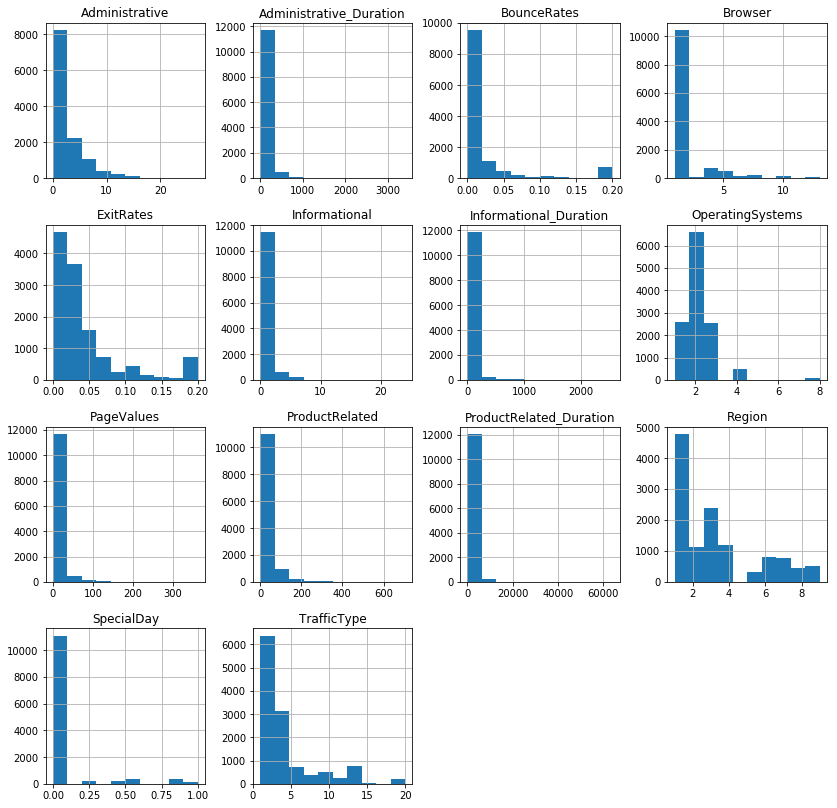

In [10]:
data[data.describe().columns].hist(figsize=(14,14));

None of the features is normally distributed, since they are highly skewed to the right, most distributions seem to follow a lognormal distribution. Initially, the one variable that catches my attention is SpeciaDay. Althoug it apparently seems like a continuous varibale, I believe it could actually be considered as either a binary or categorical feature. Let's look closer at its content.

In [11]:
#Get value counts for SpecialDay
data.SpecialDay.value_counts()

0.0    11079
0.6      351
0.8      325
0.4      243
0.2      178
1.0      154
Name: SpecialDay, dtype: int64

This variable would be better considered as categorical since it has only 6 values and eventhough they are numerical, they are not relationable amongts each other. The lowest value of zero means that the date when the user accessed the webstie is not a special day or even close to it, the value increases as it gets closer the the special day. The highest value of 1 means the user visited the website on a special day. Special day refers to holidays or special occassions such as Mother's Day, Valentine's Day, etc.

Now I will look at the non-numerical variables in the dataset.

In [144]:
#Get non-numerical features.
non_num_cols = list(set(data.columns) - set(data.describe().columns))
print('Non-numerical features: ',non_num_cols)

Non-numerical features:  ['VisitorType', 'Month', 'Revenue', 'Weekend']


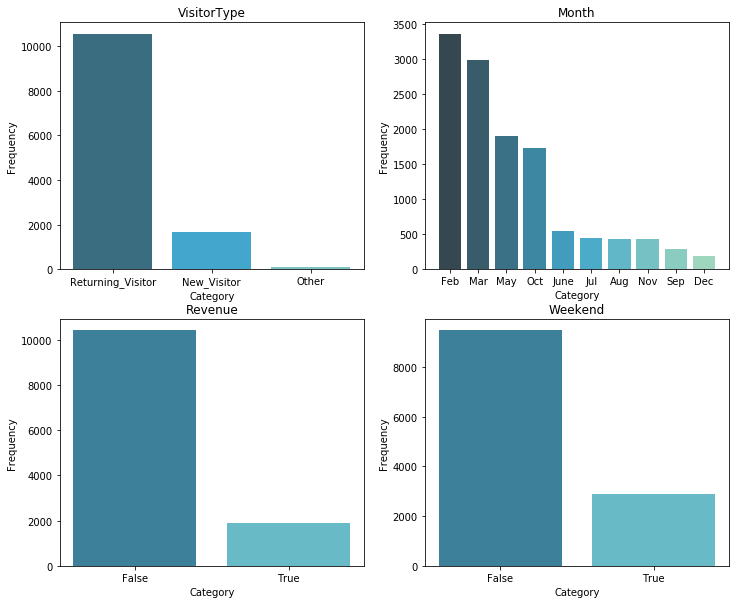

In [183]:
#Instantiate a 2x2 figure for the 4 plots.
fig, axs = plt.subplots(2, 2,figsize=(12,10))
#Create a bar chart for each of the non-numerical variables.
for i, col in enumerate(non_num_cols):
    #Helper variables to assign the correct axes to each of the 4 plots.
    j=i//2
    k=i%2
    #Setting a color palette for the plots.
    color = sns.color_palette("GnBu_d",n_colors=len(data[col].unique()))
    #Create the bar plot.
    axs[j,k].bar(data[col].astype('str').unique(), data[col].value_counts(), color= color)
    axs[j,k].set_title(col)
    axs[j,k].set_ylabel('Frequency')
    axs[j,k].set_xlabel('Category')
plt.show();

The only feature that draws my attention amongst this non-numerical features is visitor-type, since it by definition be a binary variable. A user is either a returning visitor or a new one. There should not be other. Now, I will take a look at its frequency to decide weather to classify those 'other' visitor-types as new_visitor or to drop them if they are outliers.

In [306]:
print(data.VisitorType.value_counts(),'\n')
print('''Number of revenue generating users as VisitorType 'Other': ''',
      data[data['VisitorType']=='Other'][data['Revenue']==True].Revenue.count())

Returning_Visitor    10551
New_Visitor           1694
Other                   85
Name: VisitorType, dtype: int64 

Number of revenue generating users as VisitorType 'Other':  16


Even though, the 'Other' category has a sample size of 85 which is very small compared to the whole data set, I will not delete it since some of the sessions resulted in revenue and might add knowledge to the model. Also, it is important to keep this category since the model will be dealing with this data in real time.

Another concern is that it appears that the incidence in the target variable shows the dataset might be imbalanced. Target incidence is defined as the number of cases of each individual target value in a dataset. Target incidence shows if  the dataset is  balanced or imbalanced. This is important since the aim of the project is to predict whether or not a user session generated revenue or not. The model for this is a binary classifier, meaning that there are only 2 possible outcomes:
1. False(value:0) - The session did not generate revenue.
2. True (value:1) - The session generated revenue.

Let's look at the incidence for both outcomes.

False    84.53
True     15.47
Name: Revenue, dtype: float64


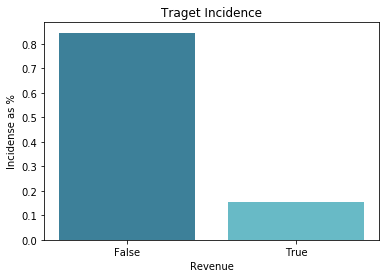

In [307]:
print(round(data.Revenue.value_counts(normalize=True),4)*100)
plt.bar(['False','True'], data.Revenue.value_counts(normalize=True), color=sns.color_palette("GnBu_d",n_colors=2))
plt.title('Traget Incidence')
plt.ylabel('Incidense as %')
plt.xlabel('Revenue')
plt.show();

A 15% target incidence considering the amount of data in the dataset could work, however the proportion is still very small and I consider it to be imbalanced. Hence, further on I will consider data augmentation techniques in order to boost the target incidence with synthetic data. Now, it is time to pre-process the data based on these findings.

## 4 Data Pre-processing and Feature Engineering
During the initial EDA I found out some variables that seemed to be numerical turned out they are better used as categorical variables. So far I have identified the following numerical features, either discrete or continuous: 'Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', and 'PageValues'. The remaining columns are to be treated as categorical features, which are: 'Month', 'OperatingSystems', 'Region', 'Revenue', 'SpecialDay', 'TrafficType', 'VisitorType', and 'Weekend'. The target variable of the dataset is 'Revenue'.

I will start by identifying the numerical and categorical feature names.

### 4.1 One-hot-code categorica features

In [314]:
#Create list with categorical features' names.
nonum_feats_names = ['Month', 'OperatingSystems', 'Region', 'Revenue', 
      'SpecialDay', 'TrafficType', 'VisitorType', 'Weekend']

#Create list with numerical features' names.
num_cols_names = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 
            'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates','PageValues']

In [316]:
#Assign appropriate data type to categorical variables.
nonum_feats = data[nonum_feats_names].astype('category')
nonum_feats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 8 columns):
Month               12330 non-null category
OperatingSystems    12330 non-null category
Region              12330 non-null category
Revenue             12330 non-null category
SpecialDay          12330 non-null category
TrafficType         12330 non-null category
VisitorType         12330 non-null category
Weekend             12330 non-null category
dtypes: category(8)
memory usage: 98.8 KB


In [322]:
#One-hot-code categorical variables and dropping the reference value.
ohc_feats = pd.get_dummies(nonum_feats,drop_first=True)
ohc_feats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 52 columns):
Month_Dec                        12330 non-null uint8
Month_Feb                        12330 non-null uint8
Month_Jul                        12330 non-null uint8
Month_June                       12330 non-null uint8
Month_Mar                        12330 non-null uint8
Month_May                        12330 non-null uint8
Month_Nov                        12330 non-null uint8
Month_Oct                        12330 non-null uint8
Month_Sep                        12330 non-null uint8
OperatingSystems_2               12330 non-null uint8
OperatingSystems_3               12330 non-null uint8
OperatingSystems_4               12330 non-null uint8
OperatingSystems_5               12330 non-null uint8
OperatingSystems_6               12330 non-null uint8
OperatingSystems_7               12330 non-null uint8
OperatingSystems_8               12330 non-null uint8
Region_2                   

Now, the categorical columns have gone up to 52 including the target variable which is going to be separated. Now that all variables are numerical, I want to test plain vanilla baseline models in the raw data to see how well they perform on data with very little pre-processing. In this case, all i have done is one hot code the categorical variables, but no transformations have been performed on the numercial features.

### 4.2 Plain Vanilla Classification Models

The classifiers that I will be testing are:
* KNeighbors
* DecisionTreeClassifier
* LinearSVC
* LogisticRegression
* RandomForestClassifier
* xgb.XGBClassifier

In [351]:
ohc_data = pd.concat([data[num_cols_names], ohc_feats.drop('Revenue_True', axis=1)],axis=1)
target = ohc_feats.Revenue_True
results1 = baseline_models(ohc_data,target)

Classification Model:  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform') 

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      2573
           1       0.62      0.29      0.39       510

   micro avg       0.85      0.85      0.85      3083
   macro avg       0.75      0.63      0.65      3083
weighted avg       0.83      0.85      0.83      3083
 

Classification Model:  DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best') 

              precision    recall  f1-score   support

           0       0.91      0.91      0.91      

In [349]:
#Display the results of the models as a dataframe
#Sort models according to f1 score.
results1.sort_values('f1',ascending=False)

,f1,accuracy,precision,recall,auc
XGBoost,0.678404,0.911126,0.706601,0.652370,0.803458
RandomForest,0.562584,0.894583,0.696667,0.471783,0.718657
LogisticRegression,0.534091,0.893610,0.720307,0.424379,0.698364
DecisionTree,0.530398,0.854687,0.495108,0.571106,0.736689
KNeighbors,0.403509,0.867661,0.572614,0.311512,0.636249
LinearSVC,0.302583,0.877392,0.828283,0.185102,0.589331


In [350]:
print('Best Model per Metric')
for metric in results1.columns:
    print(f'{metric.capitalize()}:',results.sort_values(metric,ascending=False).index[0])

Best Model per Metric
F1: XGBoost
Accuracy: XGBoost
Precision: LogisticRegression
Recall: XGBoost
Auc: XGBoost


In [17]:
num_cols = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 
            'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates','PageValues']
scaler = StandardScaler()
to_scale = data[num_cols]
scaled_df = scaler.fit_transform(to_scale)
scaled_df = pd.DataFrame(scaled_df,columns=num_cols)
scaled_df.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues
count,1.233000e+04,1.233000e+04,1.233000e+04,1.233000e+04,1.233000e+04,1.233000e+04,1.233000e+04,1.233000e+04,1.233000e+04
mean,-1.375191e-15,2.074316e-15,6.987391e-15,1.765777e-16,-2.849753e-16,1.021684e-15,1.333384e-15,-2.622846e-16,-4.953810e-15
std,1.000041e+00,1.000041e+00,1.000041e+00,1.000041e+00,1.000041e+00,1.000041e+00,1.000041e+00,1.000041e+00,1.000041e+00
min,-6.969930e-01,-4.571914e-01,-3.964779e-01,-2.449305e-01,-7.134884e-01,-6.243475e-01,-4.576830e-01,-8.863706e-01,-3.171778e-01
25%,-6.969930e-01,-4.571914e-01,-3.964779e-01,-2.449305e-01,-5.560920e-01,-5.281214e-01,-4.576830e-01,-5.923930e-01,-3.171778e-01
50%,-3.959377e-01,-4.147639e-01,-3.964779e-01,-2.449305e-01,-3.087548e-01,-3.113566e-01,-3.934903e-01,-3.686913e-01,-3.171778e-01
75%,5.072280e-01,7.035981e-02,-3.964779e-01,-2.449305e-01,1.409492e-01,1.407881e-01,-1.109348e-01,1.425510e-01,-3.171778e-01
max,7.431499e+00,1.876956e+01,1.849960e+01,1.786868e+01,1.513858e+01,3.280678e+01,3.667189e+00,3.229316e+00,1.916634e+01


In [18]:
final_data = pd.concat([scaled_df,ohc_feats],axis=1)
final_data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,Month_Dec,...,TrafficType_3,TrafficType_4,TrafficType_5,TrafficType_6,TrafficType_7,TrafficType_8,TrafficType_9,VisitorType_Other,VisitorType_Returning_Visitor,Weekend_True
0,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,3.667189,3.229316,-0.317178,0,...,0,0,0,0,0,0,0,0,1,0
1,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.590903,-0.457683,1.171473,-0.317178,0,...,0,0,0,0,0,0,0,0,1,0
2,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,3.667189,3.229316,-0.317178,0,...,1,0,0,0,0,0,0,0,1,0
3,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.622954,0.573535,1.994610,-0.317178,0,...,0,1,0,0,0,0,0,0,1,0
4,-0.696993,-0.457191,-0.396478,-0.244931,-0.488636,-0.296430,-0.045196,0.142551,-0.317178,0,...,0,1,0,0,0,0,0,0,1,1


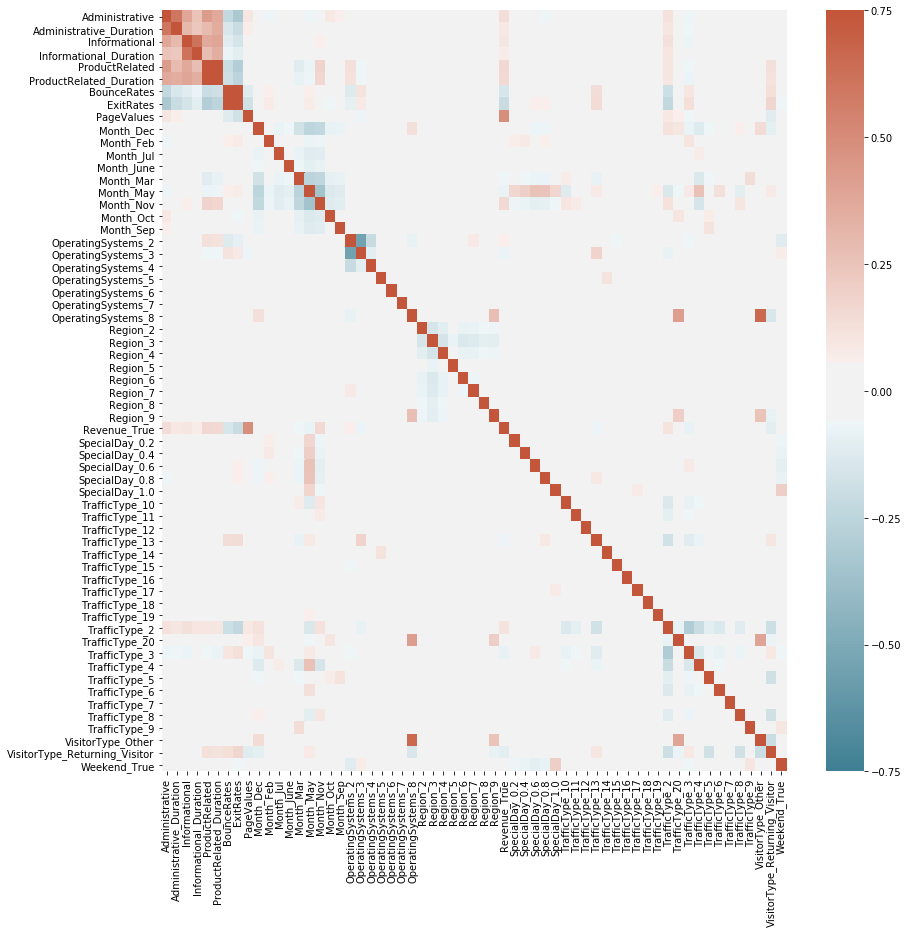

In [29]:
plt.figure(figsize=(14,14))
cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
sns.heatmap(final_data.corr(),vmin=-0.75,vmax=0.75,center=0, cmap=cmap);

In [46]:
corr = pd.DataFrame(final_data.corr(),)
corr.Revenue_True.sort_values(ascending=False)[1:11]

PageValues                 0.492569
ProductRelated             0.158538
Month_Nov                  0.154774
ProductRelated_Duration    0.152373
Administrative             0.138917
TrafficType_2              0.116347
Informational              0.095200
Administrative_Duration    0.093587
Informational_Duration     0.070345
OperatingSystems_2         0.060040
Name: Revenue_True, dtype: float64

In [47]:
target = final_data['Revenue_True']
feat = final_data.drop('Revenue_True', axis=1)

In [53]:
pca = PCA(n_components=.9)
pca_feats = pca.fit_transform(feat)
print(np.sum(pca.explained_variance_ratio_))
pca.n_components_

0.90536213197346


17

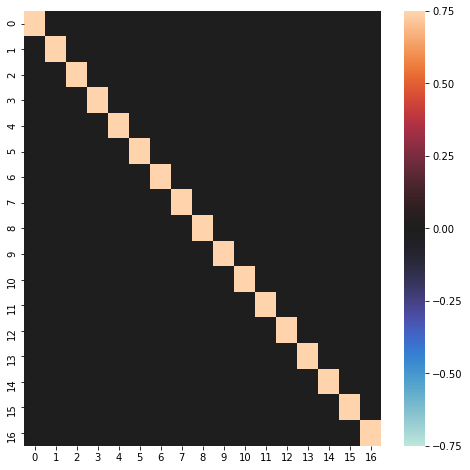

In [54]:
plt.figure(figsize=(8,8))
sns.heatmap(pd.DataFrame(pca_feats).corr(),vmin=-0.75,vmax=0.75,center=0);

In [ ]:
X_train, X_test, y_train,y_test = 

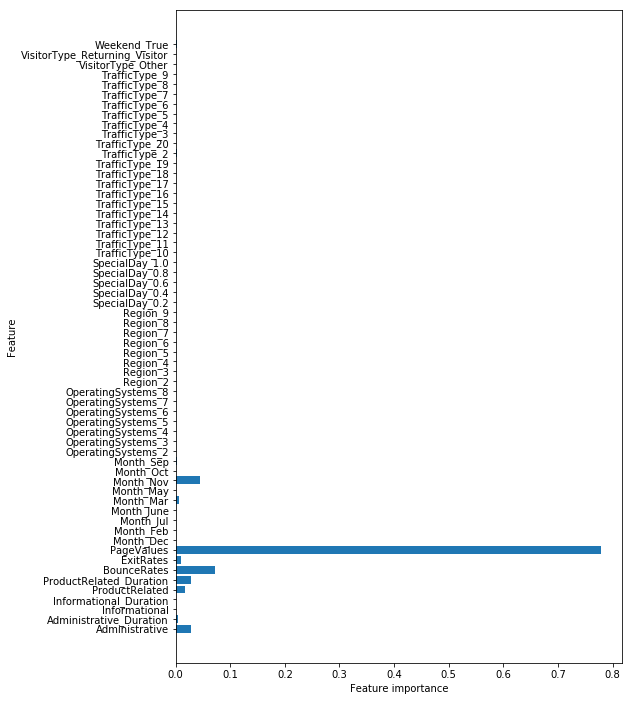

In [73]:
tree_clf = DecisionTreeClassifier() 
tree_clf.fit(feat, target)
def plot_feature_importances(model):
    n_features = feat.shape[1]
    plt.figure(figsize=(8,12))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), feat.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.show();

plot_feature_importances(tree_clf)

In [89]:
X_train, X_test, y_train, y_test = train_test_split(feat,target,test_size=0.35,random_state=617)

In [197]:
pipeline_optimizer = TPOTClassifier(generations=5, population_size=20, cv=5,
                                    random_state=42, verbosity=2, scoring='f1')
pipeline_optimizer.fit(X_train, y_train)
print(pipeline_optimizer.score(X_test, y_test))

Generation 1 - Current best internal CV score: 0.6759315464279728
Generation 2 - Current best internal CV score: 0.6759315464279728
Generation 3 - Current best internal CV score: 0.6759315464279728
Generation 4 - Current best internal CV score: 0.6776836303922799
Generation 5 - Current best internal CV score: 0.6789019388024096

Best pipeline: RandomForestClassifier(LinearSVC(input_matrix, C=1.0, dual=False, loss=squared_hinge, penalty=l1, tol=0.1), bootstrap=True, criterion=entropy, max_features=0.35000000000000003, min_samples_leaf=16, min_samples_split=10, n_estimators=100)
0.6451063829787235


In [225]:
clf = RandomForestClassifier(bootstrap=True, criterion='entropy',max_features=0.4, 
                             min_samples_leaf=17, min_samples_split=10, n_estimators=100)
clf.fit(X_train, y_train)
test_preds = clf.predict(X_test)
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

           0       0.93      0.96      0.94      3667
           1       0.71      0.59      0.65       649

   micro avg       0.90      0.90      0.90      4316
   macro avg       0.82      0.78      0.79      4316
weighted avg       0.90      0.90      0.90      4316



In [90]:
clf = KNeighborsClassifier()
clf.fit(X_train, y_train)
test_preds = clf.predict(X_test)
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

           0       0.90      0.96      0.93      3667
           1       0.66      0.43      0.52       649

   micro avg       0.88      0.88      0.88      4316
   macro avg       0.78      0.69      0.72      4316
weighted avg       0.87      0.88      0.87      4316



In [92]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
test_preds = clf.predict(X_test)
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      3667
           1       0.56      0.57      0.56       649

   micro avg       0.87      0.87      0.87      4316
   macro avg       0.74      0.74      0.74      4316
weighted avg       0.87      0.87      0.87      4316



## 7. Bibliography and References
* Dataset: Sakar, C.O., Polat, S.O., Katircioglu, M. et al. Neural Comput & Applic (2018). https://link.springer.com/article/10.1007%2Fs00521-018-3523-0

In [227]:
data.var()

Administrative             1.103425e+01
Administrative_Duration    3.125085e+04
Informational              1.613297e+00
Informational_Duration     1.981036e+04
ProductRelated             1.978070e+03
ProductRelated_Duration    3.662130e+06
BounceRates                2.351117e-03
ExitRates                  2.361624e-03
PageValues                 3.447868e+02
SpecialDay                 3.956808e-02
OperatingSystems           8.305129e-01
Browser                    2.949039e+00
Region                     5.767640e+00
TrafficType                1.620199e+01
Weekend                    1.785135e-01
Revenue                    1.308093e-01
dtype: float64